# DRIVE MOUNT

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# IMPORTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, CuDNNLSTM, LSTM, Conv1D,UpSampling1D, MaxPool1D,MaxPooling1D, Permute, Reshape
from keras.optimizers import RMSprop, adam
from keras.utils import to_categorical

import pywt
import pandas as pd
from matplotlib import cm

from mpl_toolkits.mplot3d import Axes3D

from imblearn.over_sampling import SMOTE
from imblearn.base import BaseSampler
from collections import Counter # counts the number of elements per class ({0: 5050, 1: 37})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# DATA PROCESSING

In [0]:
def RPN(x):
    '''
    Calcule la RPN d'un signal (Relative Power Noise)
    input :
        x = array numpy, le signal dont on souhaite calculer la RPN
        
    output :
        x_RPN = array numpy, la RPN du signal
        '''
    mean = np.mean(x,axis=1).reshape(x.shape[0],1)
    return (x-mean)/mean
  
def shuffle(x,y):
    # shuffle
    index = np.arange(y.shape[0])
    np.random.shuffle(index)
    x = x[index]
    y = y[index]
    
    return x,y
    
def bootstrap(x_train,y_train,inv=True) :
    if inv :
      x_train,y_train = inv_data(x_train,y_train)
      
    x_train1 = x_train[np.where(y_train == 1)[0]] #Separation du train_set selon le label
    x_train0 = x_train[np.where(y_train == 0)[0]]
    index_train = np.random.randint(0,x_train1.shape[0] , size=x_train0.shape[0]) #genere une liste d'index 
                                                                                  #aléatoire pour equilibrer les données
    x_train_1_boot = x_train1[index_train]
    y_train_boot = np.concatenate((np.ones(x_train0.shape[0]),np.zeros(x_train0.shape[0]))) #on génère une liste de labels avec autant de 1 que de 0
    x_train_boot = np.concatenate((x_train_1_boot,x_train0)) #on rassemble les données une fois équilibrées
    
    x_train_boot,y_train_boot  = shuffle(x_train_boot,y_train_boot)
    
    return x_train_boot,y_train_boot

def dataload(path='data/',merge=True) :
    # Loading datas
    data_train = pd.read_csv(path+'exoTrain.csv')
    data_test = pd.read_csv(path+'exoTest.csv')
    
    # transformation des label en array de 0 et 1
    y_train = np.array(data_train["LABEL"])-1
    y_test = np.array(data_test['LABEL'])-1
    
    # on charge les features
    x_train = np.array(data_train.drop('LABEL',axis=1))
    x_test = np.array(data_test.drop('LABEL',axis=1))
    
    if merge :
      data = np.concatenate((x_train,x_test))
      y = np.concatenate((y_train,y_test))
      data0 = data[np.where(y==0)[0]]
      y0 = y[np.where(y==0)[0]]
      data1 = data[np.where(y==1)[0]]
      y1 = y[np.where(y==1)[0]]
      
      x_train0,x_test0,y_train0,y_test0 = train_test_split(data0,y0, test_size = 0.1)
      x_train1,x_test1,y_train1,y_test1 = train_test_split(data1,y1, test_size = 0.1)
      
      x_train = np.concatenate((x_train0,x_train1))
      y_train = np.concatenate((y_train0,y_train1))
      x_test = np.concatenate((x_test0,x_test1))
      y_test = np.concatenate((y_test0,y_test1))
      
      x_train,y_train = shuffle(x_train,y_train)
      x_test,y_test = shuffle(x_test,y_test)
    
    return x_train,y_train,x_test,y_test

def pcaPlot(X, y, descr= 'temporel',plot_samples = 500):
  '''
  Defines and 10 components PCA of the dataset X and plots the first 3
  '''
  pca = PCA(n_components=10)
  x_PCA = pca.fit_transform(X)

  # let's visualize the data in 3d
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_zlabel('Principal Component 3', fontsize = 15)
  ax.set_title('ACP du signal ' + descr, fontsize = 20)
  targets = [0,1]
  colors = ['b', 'r']
  x_PCA_plot = x_PCA[0:plot_samples]

  for target, color in zip(targets,colors):
      indexes = np.where(y[0:plot_samples] == target)
      ax.scatter(x_PCA_plot[indexes,0]
                , x_PCA_plot[indexes,1],
                x_PCA_plot[indexes,2]
                , c = color
                , s = 50)
  ax.legend(['pas d\'exoplanetes', 'exoplanetes'])
  ax.grid()
  plt.show()
  return None

#Make an identity sampler
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y

def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

def SMOTE_plot(x_train, y_train):
  sampler = FakeSampler()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
  plot_resampling(x_train, y_train, sampler, ax1)
  ax1.set_title('Original data - y={}'.format(Counter(y_train)))

  plot_resampling(x_train, y_train, SMOTE(random_state = 0), ax2)
  ax2.set_title('Resampling using {}'.format(SMOTE(random_state=0).__class__.__name__))
  fig.tight_layout()
  plt.show()
  return None

def transform_dataset(X, mode='wavelet', wname='db5',nsamples=10):
  if mode == 'wavelet':
    return pywt.dwt(X, wname)[0][:,0:nsamples]

  elif mode == 'fft':
    return np.abs(np.fft.fft(X))[:,0:nsamples]

  elif mode == 'all_in':
    allz = np.abs(np.fft.fft(X))[:,0:nsamples]
    wnames = ['db5','sym5','coif5','bior2.4']
    for wn in wnames:
      np.append(allz, pywt.dwt(X, wn)[0][:,0:nsamples], axis=1)
    return allz

def scale_datasets(X_train, X_test, param='standardScaling', reshape=True):
  SC = StandardScaler()
  train_shape = X_train.shape
  test_shape = X_test.shape
    
  if param == 'standardScaling':
    SC.fit(X_train)
    if reshape:
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1],1), SC.transform(X_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return SC.transform(X_train), SC.transform(X_test)

  elif param == 'RPN':
    
    mean_train = np.mean(X_train,axis=1).reshape(X_train.shape[0],1)
    mean_test = np.mean(X_test,axis=1).reshape(X_test.shape[0],1)
    
    norm_train = np.max(np.abs(X_train),axis=1).reshape(-1,1)#np.linalg.norm(X_train,axis=1).reshape(-1,1)
    norm_test = np.max(np.abs(X_test),axis=1).reshape(-1,1)#np.linalg.norm(X_test,axis=1).reshape(-1,1)
    
    if reshape:
      return ((X_train-mean_train)/norm_train) .reshape(train_shape[0],train_shape[1],1) , ((X_test-mean_test)/norm_test) .reshape(test_shape[0],test_shape[1],1)
    else :
      return ((X_train-mean_train)/norm_train)  , ((X_test-mean_test)/norm_test) 
    
    
  elif param == 'transpose':
    X_train = np.transpose(X_train)
    if train_shape != test_shape :
      X_test = np.tile(X_test,(10,1))[0:train_shape[0]]
    X_test = np.transpose(X_test)
    SC.fit(X_train)
    if reshape:
      return np.transpose(SC.transform(X_train)).reshape(train_shape[0],train_shape[1],1), np.transpose(SC.transform(X_test))[0:test_shape[0]].reshape(test_shape[0],test_shape[1],1)
    else :
      return np.transpose(SC.transform(X_train)), np.transpose(SC.transform(X_test))[0:test_shape[0]]
    
  elif param == 'flatten':
    X_train = X_train.flatten().reshape((-1,1))
    X_test = X_test.flatten().reshape((-1,1))
    SC.fit(X_train)
    if reshape:
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1],1), SC.transform(X_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return SC.transform(X_train).reshape(train_shape[0],train_shape[1]), SC.transform(X_test).reshape(test_shape[0],test_shape[1])
  
  elif param == 'norm':
    norm_train = np.linalg.norm(X_train,axis=1).reshape(-1,1)
    norm_test = np.linalg.norm(X_test,axis=1).reshape(-1,1)
    if reshape:
      return (X_train/norm_train).reshape(train_shape[0],train_shape[1],1), (X_test/norm_test).reshape(test_shape[0],test_shape[1],1)
    else :
      return X_train/norm_train, X_test/norm_test
    
  elif param == 'norm_flatten':
    norm_train = np.linalg.norm(X_train)
    norm_test = np.linalg.norm(X_test,axis=1).reshape(-1,1)
    if reshape:
      return (X_train/norm_train).reshape(train_shape[0],train_shape[1],1), (X_test/norm_train).reshape(test_shape[0],test_shape[1],1)
    else :
      return X_train/norm_train, X_test/norm_train

def inv_data(X, y):
  X_flipped = np.flip(X[np.where(y == 1)[0]], 1)
  y_flipped = np.ones((X_flipped.shape[0]))
  return np.concatenate((X, X_flipped)), np.concatenate((y, y_flipped))

# METRICS


In [0]:
def getScores_cross(pred, result, display=False):
  confusion = confusion_matrix(result, pred)
  
  if display:
    print('Precision :')
    print(precision_score(result, pred))
    print('Recall :')
    print(recall_score(result, pred))
    print('F1 Score :')
    print(f1_score(result, pred))
    print('MSE :')
    print('')
    print(mean_squared_error(result, pred))
    print('confusion_matrix : ')
    print(confusion)
    print('')
  
  return confusion 

def recall(y_true, y_pred):
  """Recall metric.
  Only computes a batch-wise average of recall.
  Computes the recall, a metric for multi-label classification of
  how many relevant items are selected.
  """
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
  """Precision metric.
  Only computes a batch-wise average of precision.
  Computes the precision, a metric for multi-label classification of
  how many selected items are relevant.
  """
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  return true_positives / (predicted_positives + K.epsilon())

def f1(y_true, y_pred):
  preci = precision(y_true, y_pred)
  rec = recall(y_true, y_pred)
  return 2*((preci*rec)/(preci+rec+K.epsilon()))


# CROSS VALIDATION


## Data load

In [0]:
def data_load_for_cross(path='drive/My Drive/M1/IA/'):
  '''
  Loads data into one single dataset. 
  Takes only the path as parameter and returns two numpy arrays X and y
  '''

  # Loading data
  data_train = pd.read_csv(path+'exoTrain.csv')
  data_test = pd.read_csv(path+'exoTest.csv')
  
  # Transform labels into arrays of zeros and ones
  y_train = np.array(data_train["LABEL"])-1
  y_test = np.array(data_test['LABEL'])-1
  
  # Load features
  x_train = np.array(data_train.drop('LABEL',axis=1))
  x_test = np.array(data_test.drop('LABEL',axis=1))
  
  # Merge datasets
  X = np.concatenate((x_train,x_test))
  y = np.concatenate((y_train,y_test))

  return X, y

In [0]:
x, y = data_load_for_cross()

## Identification of data causing issues


### NNet

In [0]:
def maxinet_ID_issue(x_train,y_train,x_test,y_test, tst=False):
  model = Sequential()

  model.add(Conv1D(16, 200, activation='relu', padding='same', input_shape=x_train.shape[1:]))
  model.add(MaxPooling1D(4, padding='same'))
  model.add(Conv1D(8, 100, activation='relu', padding='same'))
  model.add(MaxPooling1D(4, padding='same'))
  model.add(Conv1D(4, 10, activation='relu', padding='same'))
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(200, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(70, return_sequences=True)) 
  model.add(Dropout(0.2))
  model.add(CuDNNLSTM(10)) 
  model.add(Dropout(0.2))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[precision]) #[f1, precision, "accuracy"]
  if tst:
    model.fit(x_train, y_train,
                    epochs=1,
                    shuffle = True,
                    batch_size=128)
  else:
    model.fit(x_train, y_train,
                    epochs=6,
                    shuffle = True,
                    batch_size=32,
                    validation_data=(x_test, y_test))
  
  return model

In [0]:
def cross_validation_ID_issue(X, y, splits=5, testing=False):
  # Separate exoplanet stars from non-exoplanet stars
  x_stars = X[np.where(y==0)]
  y_stars = y[np.where(y==0)]
  x_exo = X[np.where(y==1)]
  y_exo = y[np.where(y==1)]

  #scaling X
  X_scaled, bbb = scale_datasets(X, X, param='RPN')

  # Create splits
  kf = KFold(n_splits=splits, random_state=None, shuffle=False)
  split_stars = kf.split(x_stars)
  split_exo = kf.split(x_exo)
  scores = np.zeros((splits, 2, 2))

  ID_issues = np.empty(splits, dtype=object) 

  for k in range(splits):
    # A bit of info
    print("Running split number ", k + 1)

    # Define splits
    spS = next(split_stars)
    spE = next(split_exo)
    idx_tra_S = spS[0]
    idx_tst_S = spS[1]
    idx_tra_E = spE[0]
    idx_tst_E = spE[1]
    

    # Create train and test sets
    x_tra = np.concatenate((x_stars[idx_tra_S], x_exo[idx_tra_E]))
    y_tra = np.concatenate((y_stars[idx_tra_S], y_exo[idx_tra_E]))
    x_tst = np.concatenate((x_stars[idx_tst_S], x_exo[idx_tst_E]))
    y_tst = np.concatenate((y_stars[idx_tst_S], y_exo[idx_tst_E]))

    # Shuffle datasets
    x_tra, y_tra = shuffle(x_tra, y_tra)
    x_tst, y_tst = shuffle(x_tst, y_tst)

    # Bootstrap datasets
    x_tra, y_tra = bootstrap(x_tra, y_tra)
    x_tst, y_tst = bootstrap(x_tst, y_tst, inv=False)

    # Scale datasets
    x_tra, x_tst = scale_datasets(x_tra, x_tst, param='RPN')

    # Run and evaluate NN
    model = maxinet_ID_issue(x_tra, y_tra, x_tst, y_tst, tst=testing)

    #predict all data to identify which data is always missclassififed
    # Indeed we noticed that when those data were not in the train it caused 
    # problems when testing and vice-versa : even when traning with it, it would fail
    pred = np.rint(model.predict(X_scaled))
    scores[k] = getScores_cross(y, pred)
    pred = pred.flatten()
    ID_issues[k] = np.where((y != pred))[0]

  return ID_issues, scores

### Training

In [82]:
ID_issues, Scores = cross_validation_ID_issue(x, y, 5, testing=False)

Running split number  1
Train on 8984 samples, validate on 2246 samples
Epoch 1/6
8984/8984 [==============================] - 47s 5ms/step - loss: 0.5781 - precision: 0.7466 - val_loss: 0.5738 - val_precision: 0.6655
Epoch 2/6
8984/8984 [==============================] - 41s 5ms/step - loss: 0.5012 - precision: 0.7606 - val_loss: 0.3339 - val_precision: 0.9387
Epoch 3/6
8984/8984 [==============================] - 42s 5ms/step - loss: 0.3639 - precision: 0.8681 - val_loss: 0.3413 - val_precision: 0.8074
Epoch 4/6
8984/8984 [==============================] - 45s 5ms/step - loss: 0.2489 - precision: 0.9224 - val_loss: 0.3854 - val_precision: 0.9594
Epoch 5/6
8984/8984 [==============================] - 49s 5ms/step - loss: 0.1482 - precision: 0.9485 - val_loss: 0.1050 - val_precision: 0.9538
Epoch 6/6
8984/8984 [==============================] - 49s 5ms/step - loss: 0.1225 - precision: 0.9522 - val_loss: 0.2121 - val_precision: 0.9712
Running split number  2
Train on 8984 samples, valid

### Previewing issue data

In [0]:
# Concatenate all index arrays
ID_issues_flatten = np.array([])
for k in range(ID_issues.shape[0]):
  ID_issues_flatten = np.concatenate((ID_issues_flatten, ID_issues[k]))

In [145]:
# Preview the score of each epoch
print(Scores.astype(int))

[[[5460    1]
  [ 155   41]]

 [[5465    2]
  [ 150   40]]

 [[3548   18]
  [2067   24]]

 [[5385    3]
  [ 230   39]]

 [[5416    1]
  [ 199   41]]]


In [0]:
# Count the number of times each index appears
unique_val, count_val = np.unique(ID_issues_flatten, return_counts=True)

In [0]:
# Isolate the indices of the data which were missclassified at each epoch (train and test likewise)
indx = np.where((count_val > 4))[0]

In [127]:
print(indx.shape) # number of points causing problems

(37,)


In [0]:
pbl = unique_val[indx].astype(int) # make sure those are ints and can therefore be used as indices

In [147]:
print(pbl) # preview the indices

[  67  253  296  421  494  622  739 1374 1381 1405 1442 1642 1680 1775
 1955 1969 2027 2048 2162 2189 2407 2410 2469 2633 2673 2864 2994 3144
 3247 3296 3305 3676 3966 4186 4631 5033 5141]


In [129]:
print(y[pbl]) # check the label of the selected data

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


The only type of data causing problems is stars whitout exoplanet orbiting them. Let's see what they look like : 

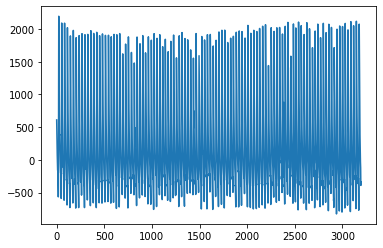

In [130]:
plt.plot(x[pbl][0])

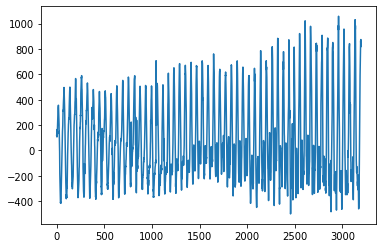

In [131]:
plt.plot(x[pbl][1])

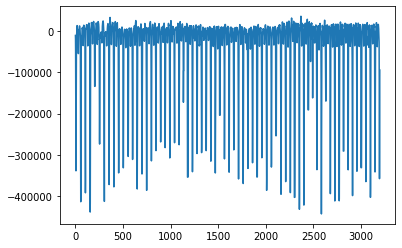

In [142]:
plt.plot(x[pbl][20])

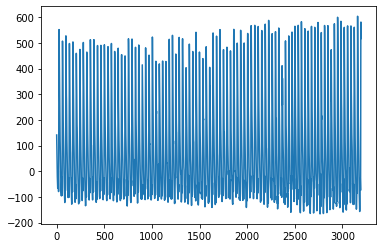

In [134]:
plt.plot(x[pbl][3])

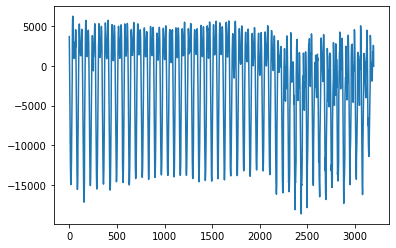

In [135]:
plt.plot(x[pbl][4])

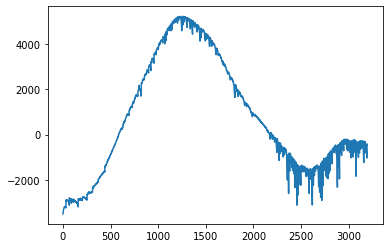

In [146]:
plt.plot(x[pbl][5])

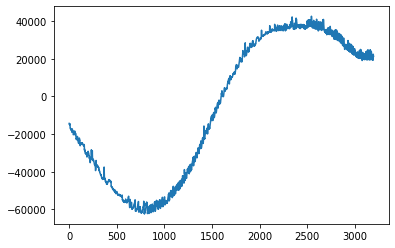

In [136]:
plt.plot(x[pbl][6])

After checking a few curves we can clearly see that either the signal doesn't look like anything or more accurately, it is nearly only noise, or either it clearly looks like a transit curve (maybe another celestial body (but not an exoplanet !) passing in front of the star (brown dwarf and such))